# 1. Primary phase concerning data exploration

# * Data Prparation *

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import numpy as np
from pyspark.ml.feature import PCA
import os

In [13]:
#re-install a module in case it shows some error in the cell above

!pip install numpy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


### Check 1: check the current working directory, Also we can change the directory using chdir() to locate the folder containing the data i.e: /home/students/s281654/

In [14]:
os.chdir('/home/students/s281654/')
!pwd

/home/students/s281654


### Step1: Import the datasets
#### The datasets (1-5) correspond to the settings of the CNC machines provided by the simulink model.

In [15]:
# data sets for each cnc machine
df1=pd.read_csv('Data/Data_01.txt') 
df2=pd.read_csv('Data/Data_02.txt') 
df3=pd.read_csv('Data/Data_03.txt') 
df4=pd.read_csv('Data/Data_04.txt') 
df5=pd.read_csv('Data/Data_05.txt') 
frames = [df1, df2, df3, df5, df4]

### Fig 1: we can plot the remaining useful life (rul) for any of the dataset as 100-usurage. 100 being the maximum rul

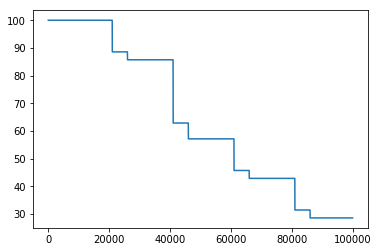

In [16]:
plt.plot(100.1-df4.usurage)

### Step 2: We define the dictionary for the settings of the CNC machine. The combination of which results in corresponding datasets

In [17]:
#settings for each cnc machine
setting_dict={'Mass':[3,2.9,3.1,2.85,3.05],
            'Resistance': [0.6,0.7,0.8,0.8,0.5],
            'Radius':[0.3,0.29,0.28,0.31,0.32],
            'Torque_const':[1.5,1.5,1.3,1.6,1.4],
             'Indcutance':[0.1,0.15,0.05,0.12,0.11],
            'Voltage_const':[0.2,0.2,0.25,0.15,0.3]
            }

### Step 3: We define a function to add these settings to the datasets as columns. To add a column simply put: df[Feature_name]= [value]
#### [CNC-id] gives a unique id to each dataset.
#### [cycle] corresponds to sampling the values for the features (similar as an index).
#### [rul] is the remaining useful life and the feature to be predicticted. 
#### [usurage] will be droped as it is the reciprocal of [rul]
#### [censor] is needed for aft-regression model.

In [18]:
# add setting to the dataset 
def add_setting(df,i):
    df['CNC_id']=i+1;
    df['cycle']= np.arange(100001)
    df['mass']= setting_dict['Mass'][i]
    df['resistance'] = setting_dict['Resistance'][i]
    df['radius']= setting_dict['Radius'][i]
    df['torque_const'] = setting_dict['Torque_const'][i]
    df['voltage_const'] = setting_dict['Voltage_const'][i]
    df['censor'] = 1
    df['rul'] = 100.1-df.usurage
    

### Step 4: We use datasets [1-4] for training and dataset 5 for testing the maching learnign model.
#### [rul] is the column to be predicted. hence it is droped from the test set and stored separately as ground truth to compute the performance metrics of the technique.
#### [Important Note] df corresponds to train_df + test_df used for vissulaiztion of both the sets together and does not play any role in training or testing phase.

In [28]:
for i,df in enumerate(frames):
    add_setting(df,i)

train_df = pd.concat(frames[0:4]).drop(columns=['usurage'])
test_rul = frames[4].rul
test_df = frames[4].drop(columns=['usurage','rul'])

df = pd.concat(frames).drop(columns=['usurage'])

### Fig [2-3] We can look at some instances from both the training and test datasets

In [20]:
train_df.tail()

,voltage,current,contact_force,angular_velocity,linear_velocity,cutter_position,F1,F2,beta,CNC_id,cycle,mass,resistance,radius,torque_const,voltage_const,censor,rul
99996,85.499999,44.999998,0,209.999994,-0.000908,-0.002289,0.002780,4.026787,0.900013,4,99996,2.85,0.8,0.31,1.6,0.15,1,0.1
99997,85.500000,45.000000,0,209.999994,-0.000820,-0.002376,0.002603,4.026787,0.900013,4,99997,2.85,0.8,0.31,1.6,0.15,1,0.1
99998,85.500000,45.000001,0,209.999996,-0.000737,-0.002454,0.002435,4.026787,0.900013,4,99998,2.85,0.8,0.31,1.6,0.15,1,0.1
99999,85.500001,45.000002,0,209.999998,-0.000660,-0.002523,0.002278,4.026787,0.900013,4,99999,2.85,0.8,0.31,1.6,0.15,1,0.1
100000,85.500001,45.000002,0,210.000000,-0.000588,-0.002586,0.002130,4.026787,0.100013,4,100000,2.85,0.8,0.31,1.6,0.15,1,0.1


In [21]:
# CNC_id 5 indicates that the 5th dataset is being used as test dataset
test_df.head()

,voltage,current,contact_force,angular_velocity,linear_velocity,cutter_position,F1,F2,beta,CNC_id,cycle,mass,resistance,radius,torque_const,voltage_const,censor
0,14.018901,0.000000,0,0.100000,0.0,0.0,0.0,4.0,0.1,5,0,3.05,0.5,0.32,1.4,0.3,1
1,32.829415,14.695170,0,7.594252,0.0,0.0,0.0,4.0,0.1,5,1,3.05,0.5,0.32,1.4,0.3,1
2,49.185785,31.447838,0,30.516310,0.0,0.0,0.0,4.0,0.1,5,2,3.05,0.5,0.32,1.4,0.3,1
3,61.996027,46.095751,0,65.549794,0.0,0.0,0.0,4.0,0.1,5,3,3.05,0.5,0.32,1.4,0.3,1
4,70.788803,56.498980,0,106.824299,0.0,0.0,0.0,4.0,0.1,5,4,3.05,0.5,0.32,1.4,0.3,1


### Step 5: store the files in gateway file system.
#### We have three types of file systems available: 1. local 2. gateway 3. cluster
#### In order to store data in the cluster we have to store it first in the gateway file system. 
#### os.remove() helps remove any existing directory to store a fresh copy. This way we can avoid confusion or conflicts.
#### os.makedirs() creates a new directory for the train, test and ground truth for test set to be stored.
#### using to_csv(), we store files in csv format and we may not include index as it is similar to [cycle] feature.

In [21]:
#os.remove('/tmp/morePro_data')

# store tain and test in the gateway
#import os  

#os.makedirs('/tmp/morePro_data', exist_ok=True) 

test_df.to_csv('/home/students/s281654/Data/train_df.csv')
test_df.to_csv('/home/students/s281654/Data/test_df.csv',index = False)
test_rul.to_csv('/home/students/s281654/Data/test_rul.csv',index = False)

#### Check 2: To verify the above operation we can list files in the corresponding directory of the gateway file system using os.listdir().
#### We can list files in the jupyter cluster using: !hadoop fs -ls [path]. 

In [121]:
#listing local vs hadoop directories

#!hadoop fs -ls '/tmp/morepro/data'
#os.listdir('/home/students/s281654/')

#### Check 3: As we used os.remove() to delete an existing directory in the gateway file system. 
#### We can remove a file from the jupyter cluster using the following command: 
#### This is useful because the file system will give an error in an attempt to over ride the existing files.  

In [114]:
#removing files from folder
!hadoop dfs -rm -r /tmp/morepro/data


22/04/12 22:46:04 INFO fs.TrashPolicyDefault: Moved: 'hdfs://BigDataHA/tmp/morepro/data' to trash at: hdfs://BigDataHA/user/s281654/.Trash/Current/tmp/morepro/data1649803564534


#### Step 6: We can make a new directory to store a fresh copy of the files using the following command:

In [115]:
#!hadoop fs -mkdir /tmp/morepro
!hadoop fs -mkdir /tmp/morepro/data

In [17]:
!hadoop fs -ls '/tmp/morepro'

Found 8 items
drwxr-x---   - s281654 supergroup          0 2022-04-13 21:24 /tmp/morepro/data
drwxr-x---   - s281654 supergroup          0 2022-04-05 16:29 /tmp/morepro/models
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelsaft
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelsdt
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelsgbt
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelslr
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelspipeline
drwxr-x---   - s281654 supergroup          0 2022-04-12 20:45 /tmp/morepro/modelsrf


#### Step 7: To push the files from gateway to the cluster we can use the following command: !hadoop fs -put [gateway file] [cluster directory]

In [116]:
# store files in hdfs
!hadoop fs -put /tmp/morePro_data/train_df.csv /tmp/morepro/data
!hadoop fs -put /tmp/morePro_data/test_df.csv /tmp/morepro/data

# * Data Exploration * 

#### check 4: [rul] should not have value = 0, This is the required for aft regression algorithm. 

In [147]:
df.rul==0

0         False
1         False
2         False
3         False
4         False
          ...  
99996     False
99997     False
99998     False
99999     False
100000    False
Name: rul, Length: 500005, dtype: bool

#### check 5: Knowing the datatypes is important as we will later define schema in the real time inference phase to parse and convert the output from the kafka-producer i.e json string into corresponding datatypes.

In [22]:
train_df.dtypes

voltage             float64
current             float64
contact_force         int64
angular_velocity    float64
linear_velocity     float64
cutter_position     float64
F1                  float64
F2                  float64
beta                float64
CNC_id                int64
cycle                 int64
mass                float64
resistance          float64
radius              float64
torque_const        float64
voltage_const       float64
censor                int64
rul                 float64
dtype: object

#### check 6: we can check the variety in the values assumed by the features.
#### setting columns usually have 4 unique values corresponding to 4 different settings.
#### [rul] has 18 unique values correponding to 18 diffent levels of rul

In [25]:
train_df.nunique()

voltage             116591
current             122163
contact_force            2
angular_velocity     98945
linear_velocity     399957
cutter_position     399957
F1                  398002
F2                     212
beta                   132
CNC_id                   4
cycle               100001
mass                     4
resistance               3
radius                   4
torque_const             3
voltage_const            3
censor                   1
rul                     18
dtype: int64

# KDE plot
#### Usually applying linear regression requires that the corresponding distribution of the label [rul] follows a gaussioan distribution.

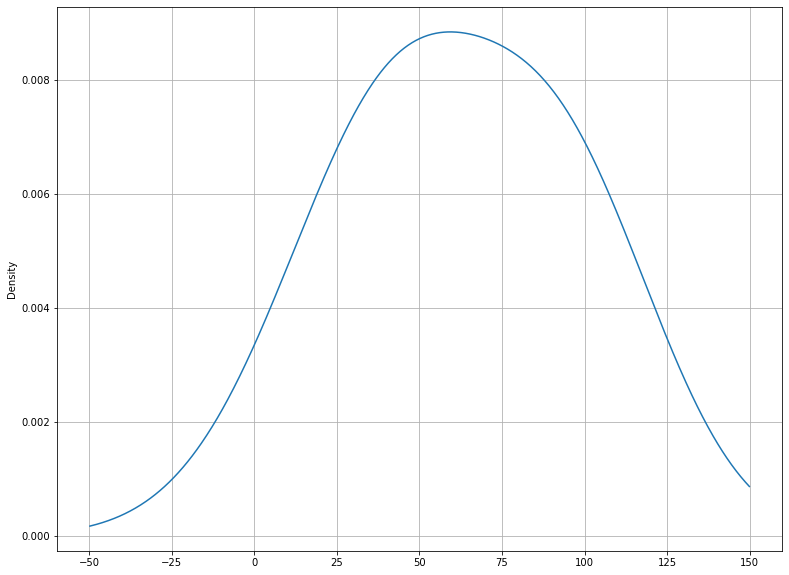

In [20]:
plt.figure(figsize=(13,10))
df.rul.plot.kde(bw_method=0.9)
plt.grid()

# Box plot
#### Helps understand if there are any outliers in the features of a dataset and also reveals if feature scaling is required so ml algorothm is not biased to a feature given high range of its values.

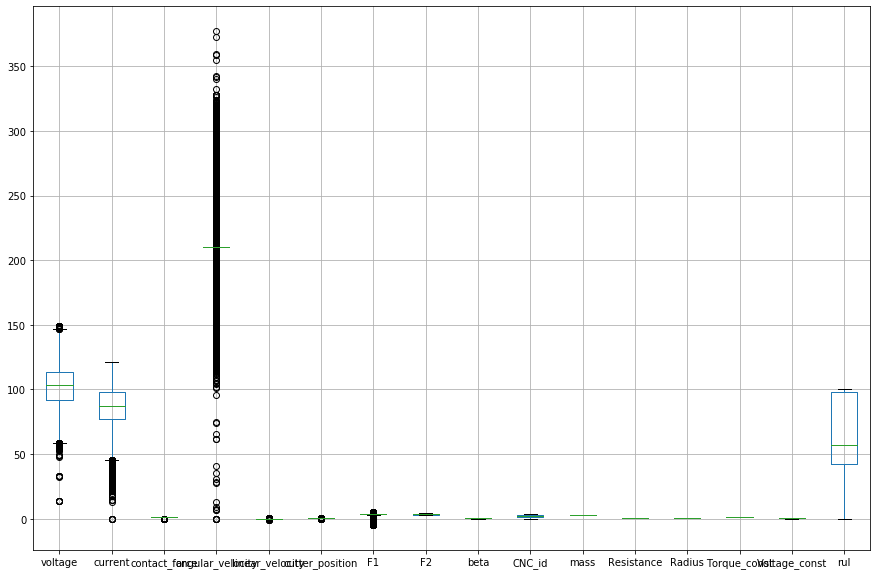

In [21]:
plt.figure(figsize=(15,10))
df.boxplot()

# Heat Map
#### reveals correlation e.g [beta] and [rul] have a strong negative correlation of -0.95

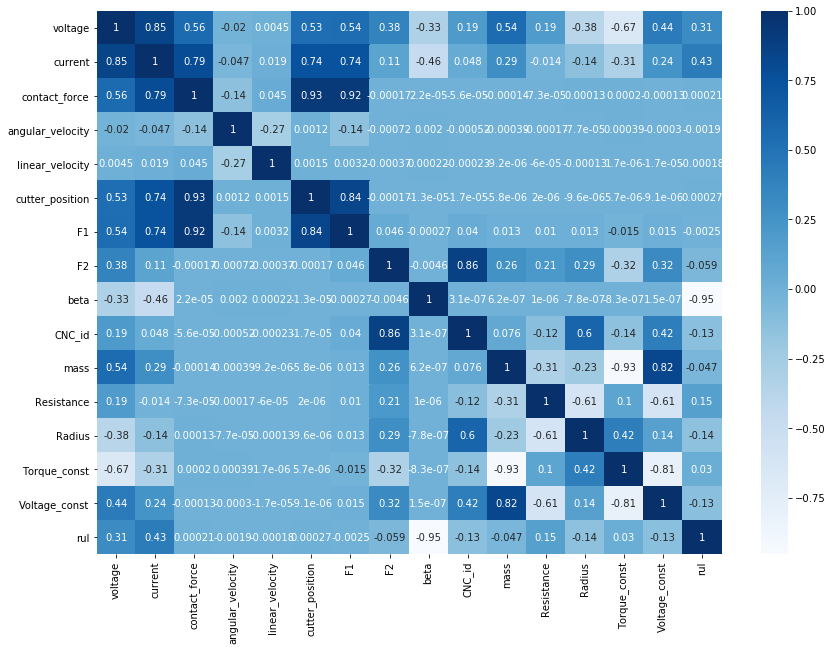

In [22]:
plt.figure(figsize=(14,10))
cor=df.corr()
sns.heatmap(cor,annot=True ,cmap=plt.cm.Blues)
plt.show()

# Scatter Plot
#### visualizes the correlation as a scatter plot between each pair of features and repressents the histogram on the diagnal of the plot

In [ ]:
axs = pd.plotting.scatter_matrix(df, figsize=(10, 10))
n = len(df.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

#### For big data processing we can levarage spark libraries. Converting pandas dataframes to spark dataframes.
#### Techniques remain similar to those of scikit-learn.

In [27]:
from pyspark import SparkConf, SparkContext
sc = SparkContext.getOrCreate()
sparkDF=spark.createDataFrame(df) 

# Correlations
#### correlation of features with the [rul] i.e the feature to be predicted.

In [73]:
for i in sparkDF.columns:
     print( "Correlation to usurage for ", i, sparkDF.stat.corr('rul',i))

Correlation to usurage for  voltage 0.31048161908348904
Correlation to usurage for  current 0.4328464740872981
Correlation to usurage for  contact_force 0.00021002387488941254
Correlation to usurage for  angular_velocity -0.0018921651309329092
Correlation to usurage for  linear_velocity -0.00017712960375810733
Correlation to usurage for  cutter_position 0.0002740292503036633
Correlation to usurage for  F1 -0.002479722789548467
Correlation to usurage for  F2 -0.05932993660011423
Correlation to usurage for  beta -0.9539490473020974
Correlation to usurage for  CNC_id -0.1270684191176641
Correlation to usurage for  mass -0.046908984954597284
Correlation to usurage for  Resistance 0.145945964030208
Correlation to usurage for  Radius -0.14251200877865886
Correlation to usurage for  Torque_const 0.030320170073574754
Correlation to usurage for  Voltage_const -0.12891772254836034
Correlation to usurage for  rul 1.0
Correlation to usurage for  censor nan


# PCA
#### mainly used for dimensionality reduction and representing the data in lower dimensional state for better vissulization.

In [42]:
pca = PCA(k=3, inputCol="features")
pca.setOutputCol("pca_features")
#model = pca.fit(vhouse_df)
model = pca.fit(scaledData)

In [43]:
model.explainedVariance

DenseVector([0.8651, 0.0699, 0.0615])

#### Figure reveals that the varience of dataset can be captured by 3 extracted features using pca

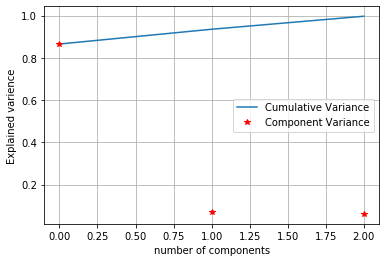

In [44]:
plt.plot(np.cumsum(model.explainedVariance))
plt.plot(model.explainedVariance,'r*')
plt.xlabel('number of components')
plt.ylabel('Explained varience');
plt.legend(['Cumulative Variance', 'Component Variance'])
plt.grid()

In [45]:
model.pc

DenseMatrix(15, 3, [-0.6856, -0.7272, -0.0090, 0.0103, -0.0, -0.0032, -0.0308, -0.0047, ..., -0.0155, -0.0055, -0.0253, -0.0027, -0.0028, 0.0004, 0.0042, -0.0012], 0)

In [41]:
v = model.pc.toArray().transpose()

#### We can relate the orignal features with the pca features. The graph reveals which orignal features played there role in determining the pca features. Also indicates that these orignal features had this impact corresponding to there variance as displayed by the box plot

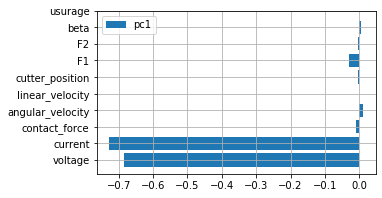

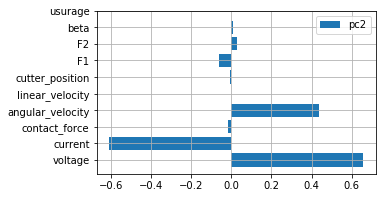

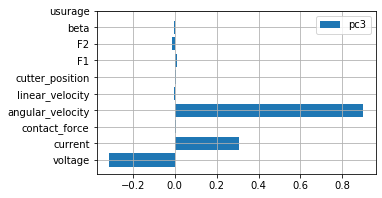

In [42]:
#loading plots
cols = df.columns
v[1].shape[0]
x=np.arange(v[1].shape[0])
locs=np.arange(cols.shape[0])

#(component : 1)--------
plt.figure(figsize=(5,3))
plt.barh(x,v[0])
plt.legend(('pc1',''))
plt.yticks(locs,cols)
plt.tight_layout
plt.grid()

#(component : 2)--------
plt.figure(figsize=(5,3))
plt.barh(x,v[1])
plt.legend(('pc2',''))
plt.yticks(locs,cols)
plt.tight_layout
plt.grid()

#(component : 3)--------
plt.figure(figsize=(5,3))
plt.barh(x,v[2])
plt.legend(('pc3',''))
plt.yticks(locs,cols)
plt.tight_layout
plt.grid()

In [46]:
transformed = model.transform(vhouse_df)
pca_score = transformed.select("pca_features")
pca_score.show(truncate=False)

+----------------------------------------------------------+
|pca_features                                              |
+----------------------------------------------------------+
|[-9.625460984337515,9.367527110043401,-4.245503948912079] |
|[-35.3647880999153,14.437771183893915,3.233027988883875]  |
|[-60.53136788558806,23.956355216820917,28.210410034946623]|
|[-80.05145649328972,38.77498148805501,64.97439942004486]  |
|[-91.79353484359387,56.93233728060658,105.55765770695207] |
|[-95.98366033638798,75.49694961052813,142.74783966071286] |
|[-94.33930378906166,91.82079148502561,171.71009076152208] |
|[-89.19649647244265,104.19875787782523,190.4295585797543] |
|[-82.8119589248149,112.03684323535511,199.33244175737855] |
|[-76.92330828285101,115.68660187047007,200.47581885859864]|
|[-72.5686820874245,116.11046205399975,196.64136923400204] |
|[-70.26725657350599,114.2142036290972,190.61500863152682] |
|[-69.25147170403656,112.34869771729879,184.38044244711298]|
|[-69.93739361326122,109

In [107]:
x = pca_score.select('pca_features').toPandas()

In [111]:
x= x['pca_features']

#### visulization of dataset in 2D corresponding to the top 2 significant pca features. 

Text(0, 0.5, 'PC 2 ')

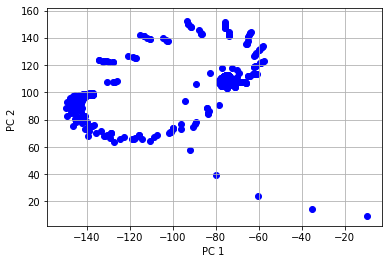

In [161]:
for i in range(10000):
    plt.scatter(x[i][0],x[i][1],c='b')
plt.grid()
plt.xlabel('PC 1 ')
plt.ylabel('PC 2 ')

#### Visualization of the orignal features on the time axis.

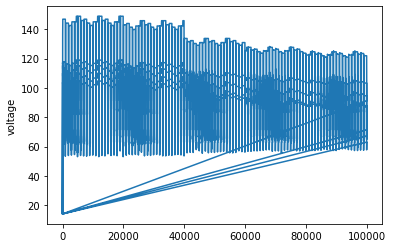

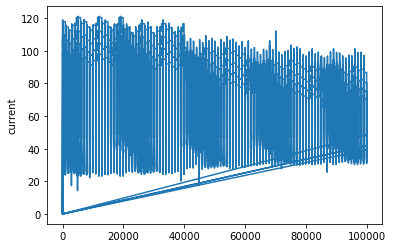

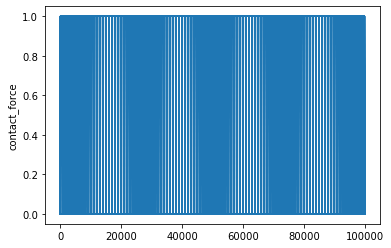

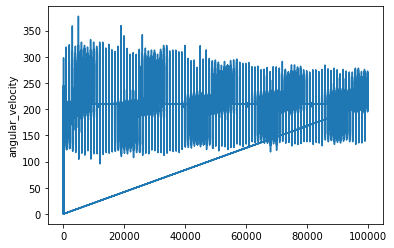

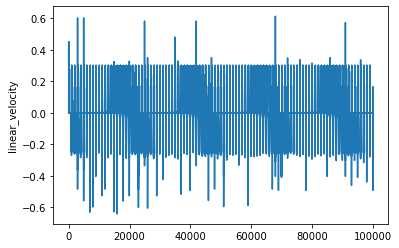

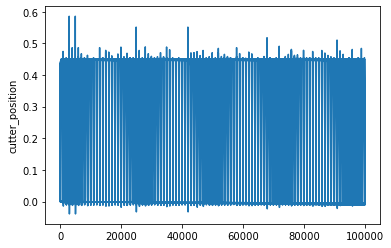

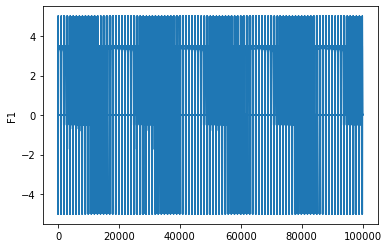

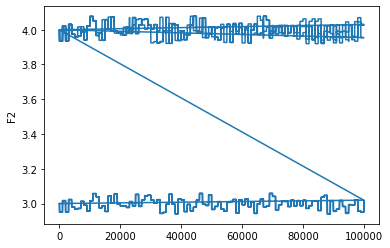

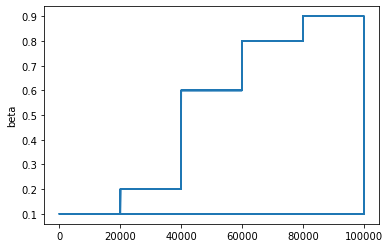

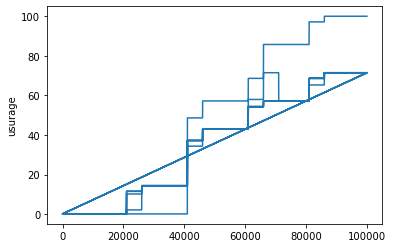

In [122]:
for idx, feature in enumerate(df.columns):
    plt.figure(idx)
    plt.plot(df[feature])
    plt.ylabel(feature)

#### * Exploration phase ends here *

In [60]:
os.listdir('/tmp/morePro_data')

['test_df.csv', 'train_df.csv']

In [81]:
os.listdir('/home/students/s281654/kafka')

['CNC_cycle_producer.ipynb', 'generic_consumer.ipynb', '.ipynb_checkpoints']

In [2]:
!hdfs dfs -ls .

Found 6 items
drwx------   - s281654 students          0 2022-04-06 17:00 .Trash
drwxr-x---   - s281654 students          0 2022-04-05 18:59 .sparkStaging
drwx------   - s281654 students          0 2021-03-08 21:18 .staging
drwxr-x---   - s281654 students          0 2022-04-03 03:01 Users
drwxr-x---   - s281654 students          0 2021-03-08 21:22 example_data
drwxr-x---   - s281654 students          0 2022-04-02 21:57 model


In [18]:
!hdfs dfs -ls model

Found 3 items
drwxr-x---   - s281654 students          0 2022-04-02 21:57 model/aft
drwxr-x---   - s281654 students          0 2022-04-02 21:57 model/formula
drwxr-x---   - s281654 students          0 2022-04-02 21:57 model/scaler
